# 문제 정의
- 문제의 종류 
  - 주식 종가(Close)로 구성된 시계열 데이터로부터 주가를 예측하는 Linear Regression 문제
- 입력 데이터
  - Close : 주식 종가
- 출력 데이터
  - Close : 입력 데이터 이후의 예상 주식 종가 수치

# 데이터 수집 및 레이블링(step1)
- Yahoo Finance의 주가 데이터 사용

# 데이터 EDA 및 전처리(step1~5)
- 데이터 EDA
  - 주가 데이터 안정성 확인 및 시계열 분석
- 데이터 전처리
  - 결측치 처리
  - 데이터 변환
  - train/test 데이터셋 분배

# 가설 및 학습 모델 설정
- 가설 수립
- 학습 모델 설정

# 학습 및 평가(step6)
- train 데이터셋을 이용한 모델 학습
- test 데이터셋 평가

# 루브릭 평가 기준
- 시계열의 안정성이 충분히 확인되었는가?
  - 플로팅과 adfuller 메소드가 모두 적절히 사용되었음
- ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?
  - p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨
- 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?
  - 3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨

# 주의사항
- colab의 statsmodels는 0.10.2 버전이기 때문에 버전 업그레이드를 통해 내장 함수를 업그레이드 해야 함.

In [47]:
!pip install --upgrade statsmodels

     |████████████████████████████████| 9.8 MB 5.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [63]:
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.5
1.0.2
0.13.2


In [2]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [3]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# 데이터 수집 및 레이블링(step1)
- Yahoo Finance의 주가 데이터 사용
- 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume' 등으로 구성
- 위의 데이터 중 Date를 인덱스로 Close 데이터를 시계열 데이터로 변환하여 사용
- 샘플 수 : 250
- 데이터 타입 : 소수형 자료

# 데이터 EDA 및 전처리(step1~5)
- 데이터 EDA
  - 주가 데이터 안정성 확인 및 시계열 분석
    - 주가의 Trend, seasonal, residual 성분 추출
    - dickey fuller 테스트를 통해 p-value와 stationary 가능성 여부 확인
    - ARIMA 모델 사용을 위한 적정 p, q, d 값 계산
- 데이터 전처리
  - 결측치 처리
    - 결측치 없음
  - 데이터 변환
    - 안정성 향상을 위한 log-scale 변환
  - train/test 데이터셋 분배
    - 주가 데이터를 9:1로 나눠 train/test 데이터셋 생성

# 가설 및 학습 모델 설정
- 가설 수립
  - 주가의 시계열 데이터 예측 문제는 데이터에서 나타나는 일정한 패턴을 기반으로 미래의 패턴을 예측하는 것이다.
  - 시계열 데이터의 통계적 특성이 변하지 않아야 예측이 가능하기 때문에 데이터를 stationary한 상태로 만들어주는 것이 중요하다. 
  - stationary한 상태 확보 방안은 아래와 같음.
  - 주가에서 작은 변동폭을 가지는 값을 노이즈 제거 필터를 사용하여 제거하고 주가의 큰 변동 흐름인 Trend를 추출한다.
  - Trend 내부에 포함된 반복 패턴인 seasonal을 차분 필터를 사용하여 제거하고 최종적으로 안정된 값인 Residual을 추출하여 예측에 사용한다.
  - 위의 과정들은 고전적인 적응형 디지털 필터 기법으로 실제 학습에서는 디지털 필터의 윈도우 크기를 결정하고 선형 회귀를 이용하여 모델이 필터 계수를 학습할 수 있도록 한다. 
- 학습 모델 설정
  - 실제 학습에서는 이 모든 과정이 패키지화 된 ARIMA 모델 함수를 사용하여 학습한다.

### STEP 1 : 시계열 데이터 준비
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

- 시계열 데이터이기 때문에 데이터를 불러올 때 날짜를 인덱스로 지정한다.
- 먼저 read_csv 함수로 데이터프레임을 저장하고 데이터프레임에서 따로 데이터를 한번 뽑아주어야 시계열 데이터가 생성된다.

In [129]:
from google.colab import files
file_uploaded = files.upload()

Saving 005930.KS.csv to 005930.KS (2).csv


In [130]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# dataset_filepath = "G:/내 드라이브/0. 인공지능 학습/아이펠 대전 3기/2. Exploration 수업/코드/3강/005930.KS.csv"

df = pd.read_csv(io.BytesIO(file_uploaded['005930.KS.csv']), index_col='Date', parse_dates=True)
df.tail()

Open     High      Low    Close  Adj Close    Volume
Date                                                               
2021-05-12  80800.0  81200.0  79800.0  80000.0    80000.0  35812268
2021-05-13  78900.0  79600.0  78400.0  78500.0    78500.0  31490096
2021-05-14  79000.0  80300.0  78900.0  80100.0    80100.0  16450920
2021-05-17  80800.0  80900.0  79200.0  79600.0    79600.0  17740855
2021-05-18  79600.0  80000.0  79100.0  79600.0    79600.0  17265868

- 데이터 프레임은 날짜를 인덱스로하는 open, high, low, close, adj close, volume 등으로 구성.
- 이 중 close column만 사용하겠음.

In [131]:
print(df.keys())
print(df.shape)
print(df.Close.dtype)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
(250, 6)
float64


In [132]:
# 데이터 프레임의 Close 열만을 따로 사용하여 시계열 데이터로 변환함.
ts = df['Close']
print(type(ts))
print('\n\n')
print(ts.tail())
print('\n\n')
print(ts.describe())

<class 'pandas.core.series.Series'>



Date
2021-05-12    80000.0
2021-05-13    78500.0
2021-05-14    80100.0
2021-05-17    79600.0
2021-05-18    79600.0
Name: Close, dtype: float64



count      250.000000
mean     68232.800000
std      13100.979613
min      48750.000000
25%      56425.000000
50%      63900.000000
75%      82175.000000
max      91000.000000
Name: Close, dtype: float64


### STEP 2 : 각종 전처리 수행
- 결측치 처리
- 로그 변환

In [133]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

- 결측치 없음

In [134]:
# 로그 변환 시도 
ts_log = np.log(ts)

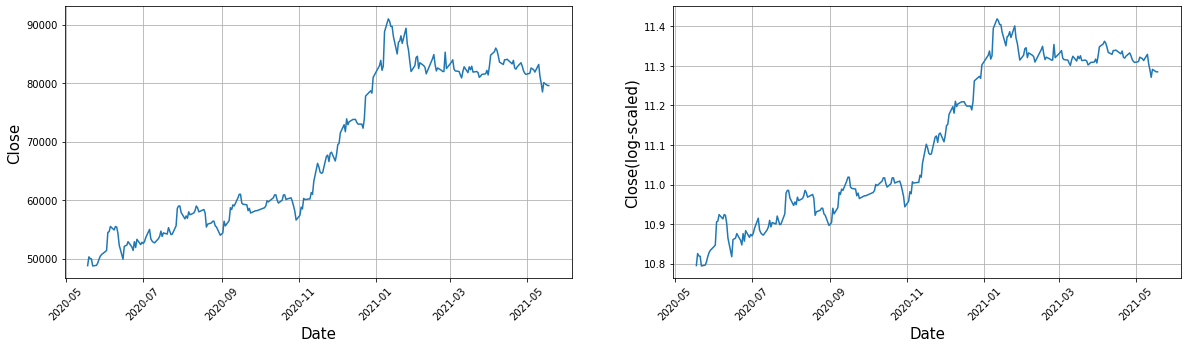

In [135]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(ts)
plt.xlabel("Date", size=15)
plt.ylabel("Close", size=15)
plt.xticks(rotation=45)
plt.grid()
plt.subplot(122)
plt.plot(ts_log)
plt.xlabel("Date", size=15)
plt.ylabel("Close(log-scaled)", size=15)
plt.xticks(rotation=45)
plt.grid()
plt.show()

- close 그래프를 보아 log 취했다고 모양 자체가 크게 변하지는 않음
- log 함수의 효과로 수치상의 변동 폭이 줄어드는 효과를 얻음

### STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [136]:
augmented_dickey_fuller_test(ts)
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


- log-scale을 통하여 큰 변화는 아니지만 0.07가량 p-value가 감소한 것을 확인함.
- 데이터를 이용하여 주가 예측을 하기에는 p-value가 높아 안정적인 시계열 데이터라고 확신하기 어려움.

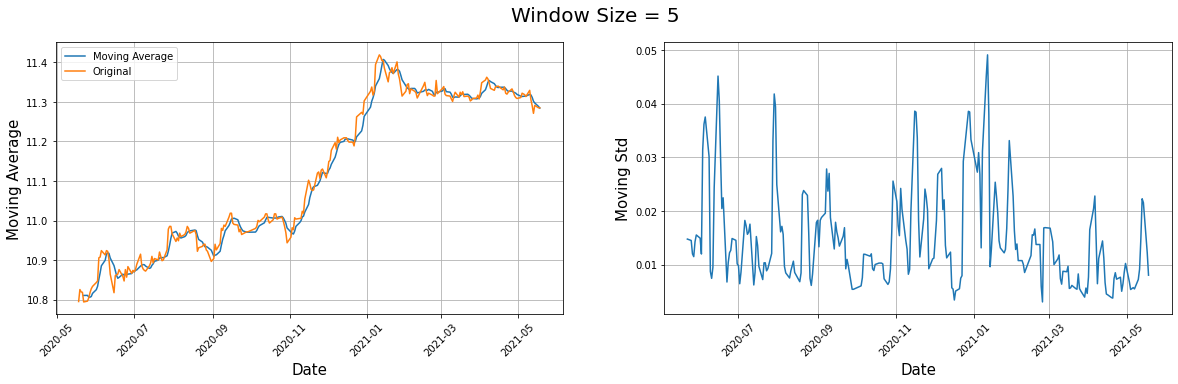

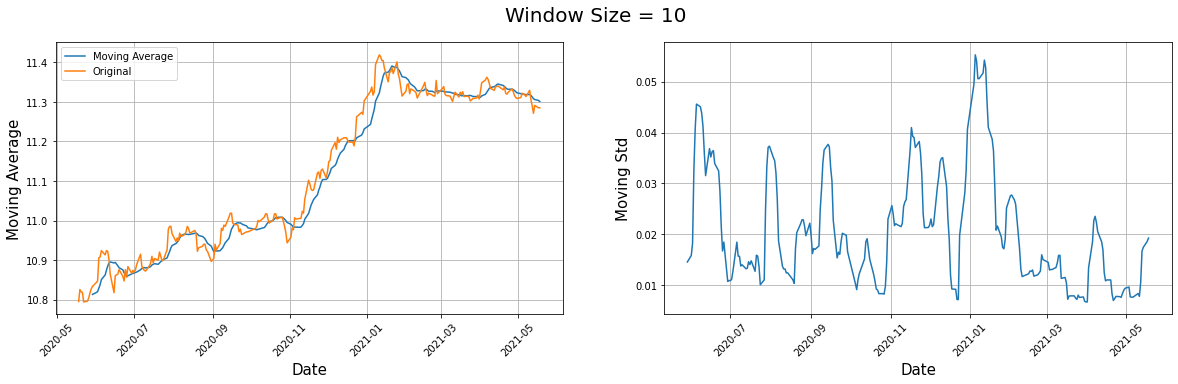

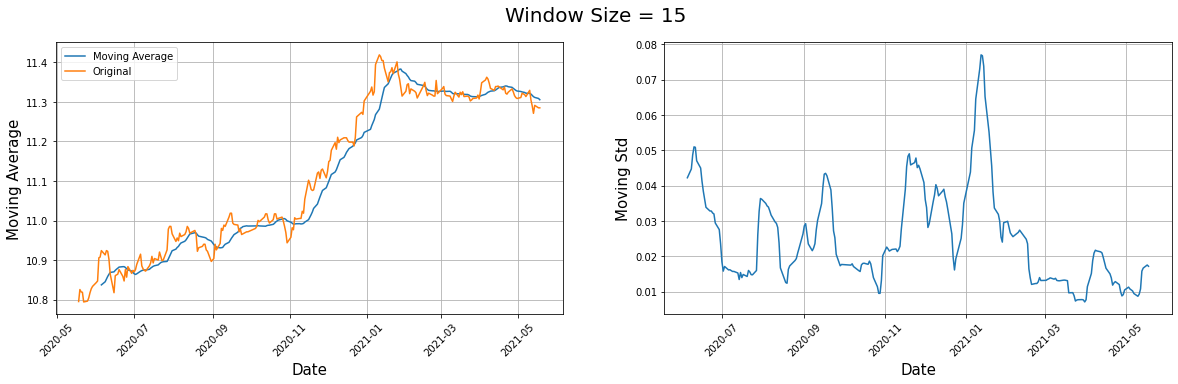

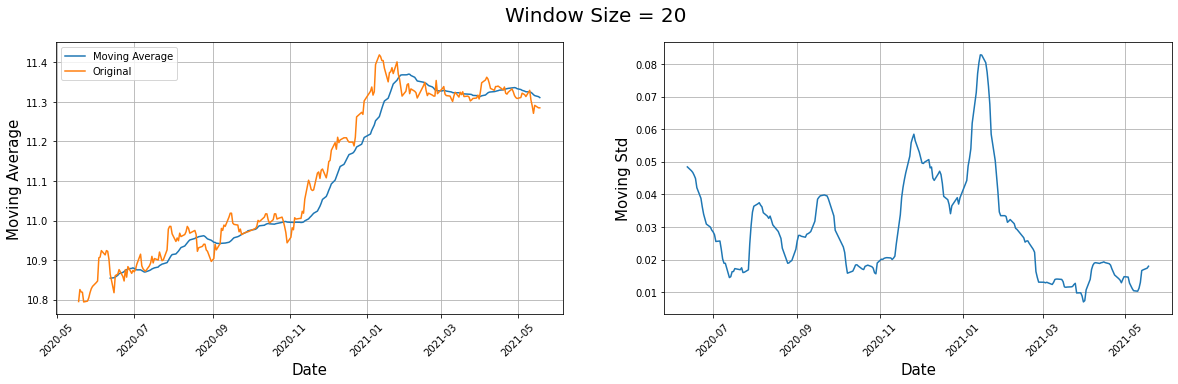

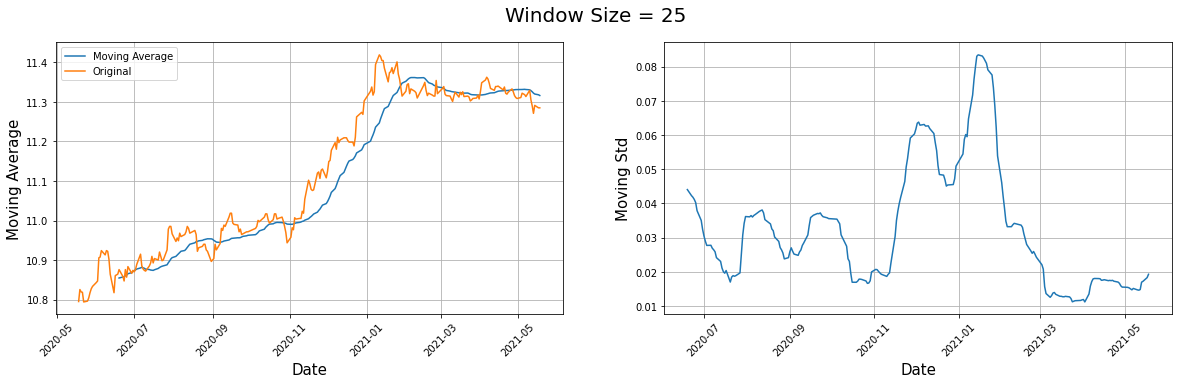

In [137]:
for i in range(5):
  window_size = 5 * (i + 1)

  rolmean = ts_log.rolling(window=window_size).mean()  # 이동평균 시계열
  rolstd = ts_log.rolling(window=window_size).std()    # 이동표준편차 시계열

  plt.figure(figsize=(20, 5))
  plt.subplot(121)
  plt.plot(rolmean, label="Moving Average")
  plt.plot(ts_log, label="Original")
  plt.legend()
  plt.xlabel("Date", size=15)
  plt.ylabel("Moving Average", size=15)
  plt.xticks(rotation=45)
  plt.grid()

  plt.subplot(122)
  plt.plot(rolstd)
  plt.xlabel("Date", size=15)
  plt.ylabel("Moving Std", size=15)
  plt.xticks(rotation=45)
  plt.grid()
  plt.suptitle("Window Size = {0}".format(window_size), fontsize=20)
  plt.show()

- 윈도우 사이즈를 변화시켜가면서 Trend(Moving Average)와 잡음(Moving Std)을 분리해보았다.
- 윈도우 사이즈가 5일 때는 Trend를 잘 반영하지만 Trend에 약간의 잡음이 끼어있는 것처럼 보인다.
- 윈도우 사이즈가 10일 때는 Trend에 잡음은 거의 사라진 듯 보이나 Trend가 점점 지연되어 나타나기 시작한다.
- 이후 윈도우 사이즈가 증가할수록 Trend가 더욱 지연되어 나타나는 것을 확인할 수 있다.

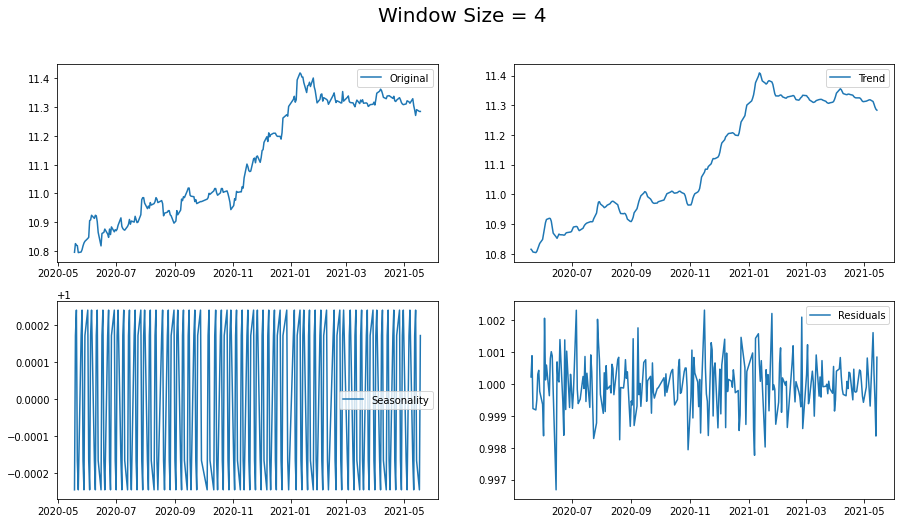

Results of Dickey-Fuller Test:
Test Statistic                -9.361960e+00
p-value                        7.779812e-16
#Lags Used                     7.000000e+00
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


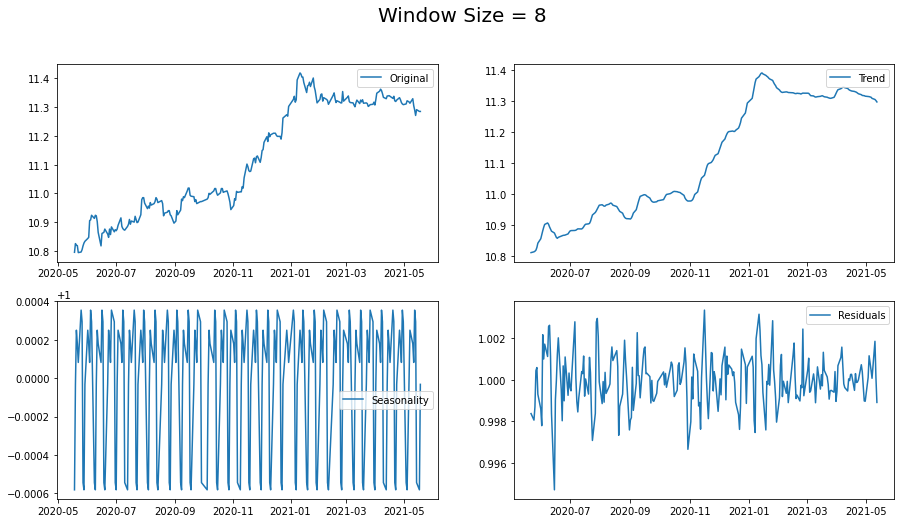

Results of Dickey-Fuller Test:
Test Statistic                -1.056608e+01
p-value                        7.511032e-19
#Lags Used                     3.000000e+00
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


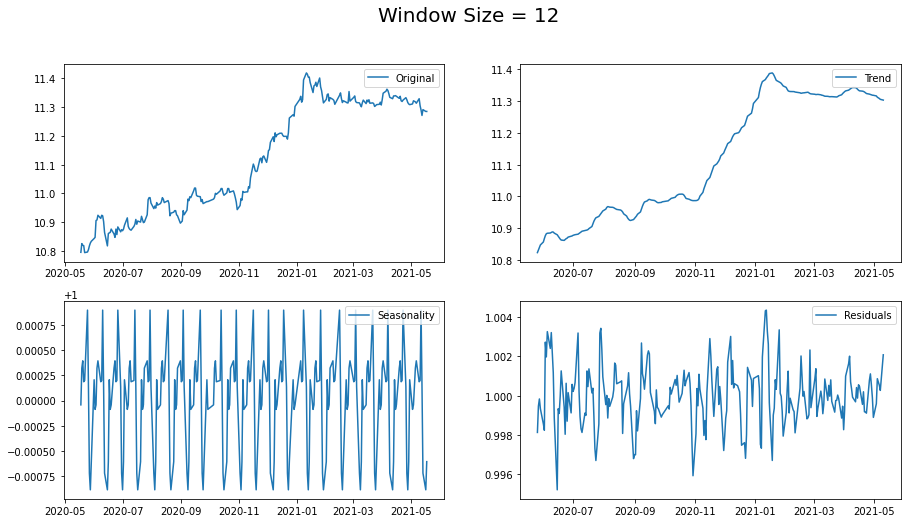

Results of Dickey-Fuller Test:
Test Statistic                -7.122093e+00
p-value                        3.699873e-10
#Lags Used                     1.200000e+01
Number of Observations Used    2.250000e+02
Critical Value (1%)           -3.459752e+00
Critical Value (5%)           -2.874473e+00
Critical Value (10%)          -2.573663e+00
dtype: float64


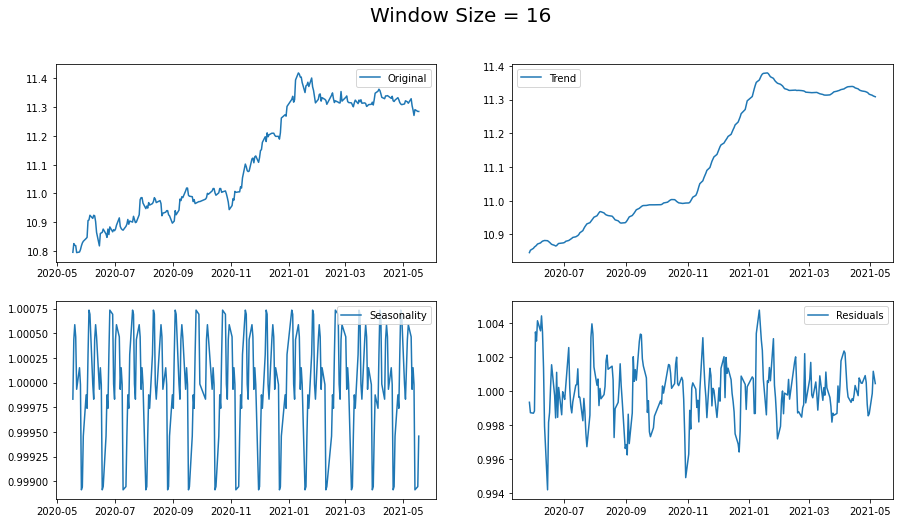

Results of Dickey-Fuller Test:
Test Statistic                -7.502085e+00
p-value                        4.227443e-11
#Lags Used                     3.000000e+00
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64


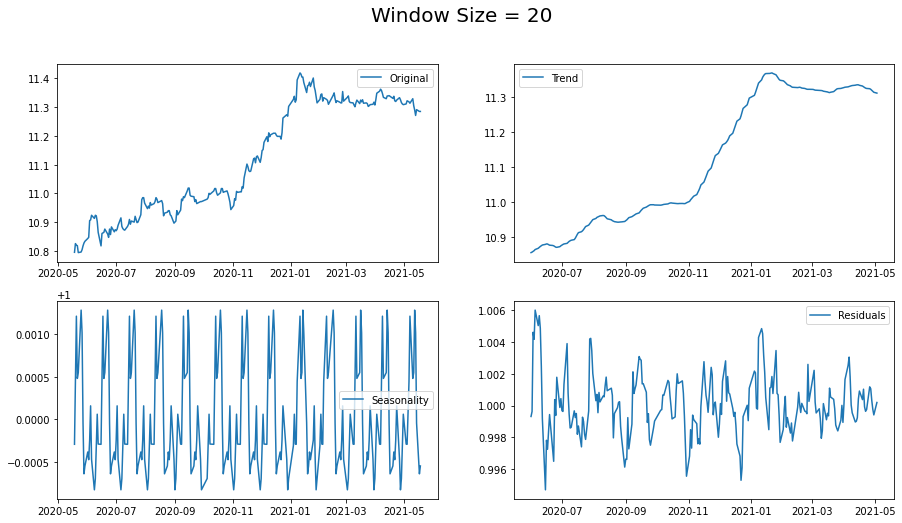

Results of Dickey-Fuller Test:
Test Statistic                -6.204111e+00
p-value                        5.712839e-08
#Lags Used                     0.000000e+00
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64


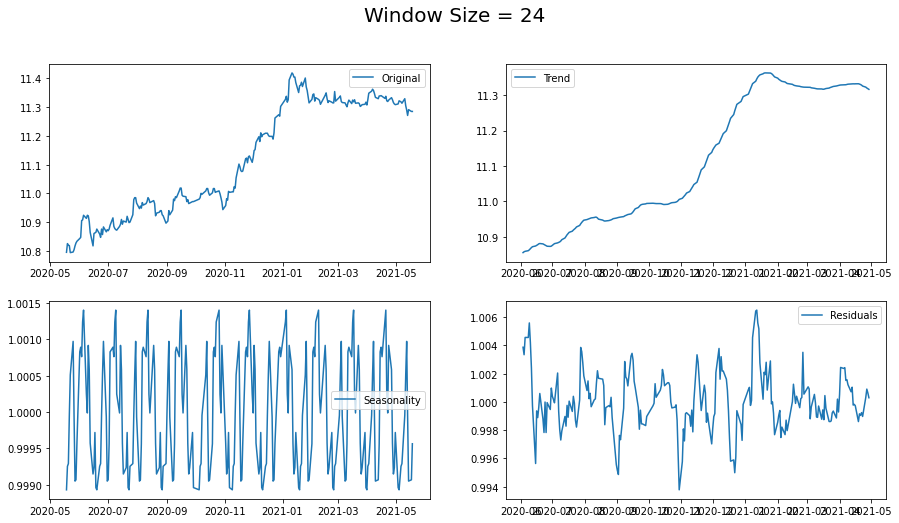

Results of Dickey-Fuller Test:
Test Statistic                -6.498310e+00
p-value                        1.179036e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


In [138]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose

for i in range(6):
  window_size = 4 * (i + 1)
  decomposition = seasonal_decompose(ts_log, model='multiplicative', period = window_size) 

  trend = decomposition.trend
  seasonal = decomposition.seasonal
  residual = decomposition.resid

  plt.figure(figsize=(15, 8))
  plt.subplot(221)
  plt.plot(ts_log, label='Original')
  plt.legend(loc='best')
  plt.subplot(222)
  plt.plot(trend, label='Trend')
  plt.legend(loc='best')
  plt.subplot(223)
  plt.plot(seasonal,label='Seasonality')
  plt.legend(loc='best')
  plt.subplot(224)
  plt.plot(residual, label='Residuals')
  plt.legend(loc='best')
  plt.suptitle("Window Size = {0}".format(window_size), fontsize=20)
  plt.show()
  
  residual.dropna(inplace=True)
  augmented_dickey_fuller_test(residual)

- seasonal_decompose 함수를 이용하여 성분 분석을 수행하였다.
- 모든 윈도우 설정에서 p-value가 0.05 이하로 낮게 나오기 때문에 모두 stationary 하다고 할 수 있다.
- 하지만 이전의 과정에서 확인하였듯이 너무 큰 윈도우 사이즈보다는 8 정도의 윈도우 사이즈를 사용하는 것이 바람직하다 생각한다.

### STEP 4 : 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

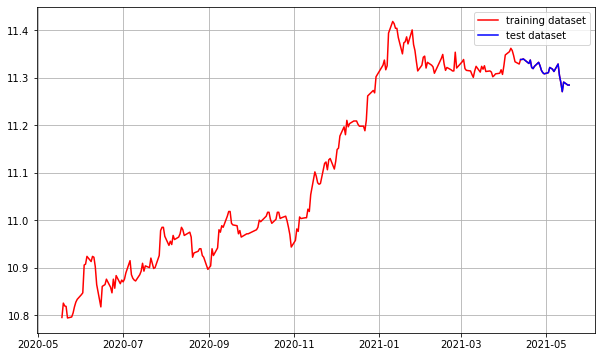

In [139]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


- 주어진 시계열 데이터를 9:1로 나눠 train/test 데이터셋을 생성한다.

### STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


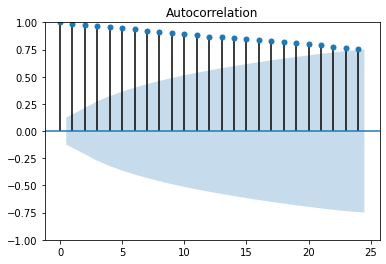

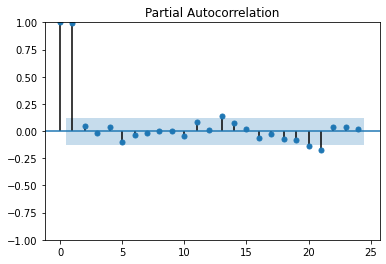

In [140]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- ACF와 PACF를 분석하여 p와 q값을 결정할 수 있다.
- ACF가 점진적으로 감소하는 경향을 보이면서 PACF는 시차 1 이후에 0에 근접한 값을 가진다. 따라서 p는 1로 설정한다.
- 또한 p와 q는 일반적으로 p + q < 2, p * q = 0인 값을 사용하기 때문에 q는 0으로 설정한다.

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


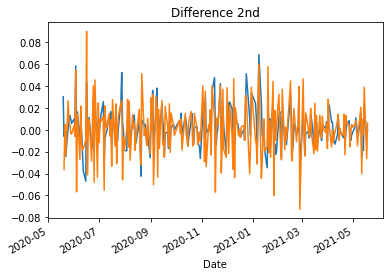

In [67]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- 차분을 수행한 후 dickey fuller 테스트를 하여 stationary한 상태를 가정할 수 있는지 확인한다.
- 1차 차분의 경우 2차 차분보다 p-value가 10^-10 배 낮은 값을 가지기 때문에 d를 1차로 설정하는 것이 적합하다.

# 학습 및 평가(step6)
- train 데이터셋을 이용한 모델 학습
  - ARIMA 모델 학습 수행
- test 데이터셋 평가

### STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [141]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 583.370
Date:                Thu, 05 May 2022   AIC                          -1158.741
Time:                        13:22:55   BIC                          -1145.076
Sample:                             0   HQIC                         -1153.226
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.127     87.360      0.000      10.841      11.338
ar.L1          0.9942      0.006    157.934      0.000       0.982       1.007
ma.L1          0.0392      0.063      0.623      0.5

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


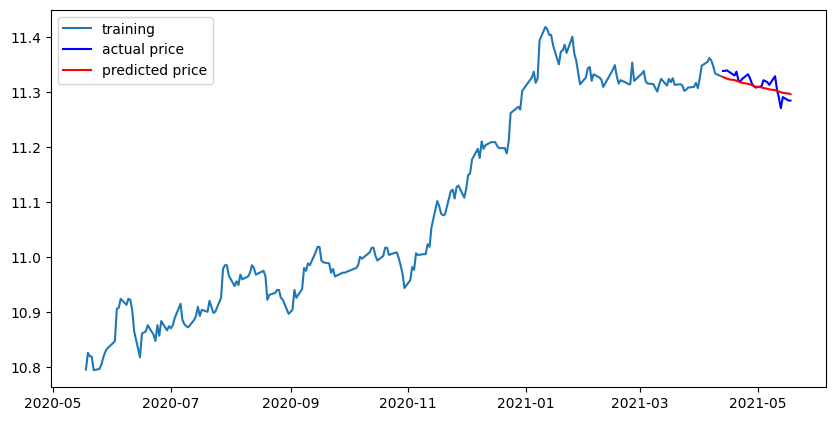

In [142]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [143]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1057119.8161341746
MAE:  850.8270312481956
RMSE:  1028.163321721882
MAPE: 1.04%


### STEP 7 : 다른 주식 종목 예측해 보기
- 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기
- 실행 결과는 아래 셀을 참조. 아래 셀의 결과에는 아무 해설도 달지 않음.
- 해당 마크다운에 모든 결과 요약함.

# 모델 평가 및 회고
- 삼성, 마이크로소프트 애플 회사 주가 데이터에 대하여 다음의 과정을 수행하였다.
- ARIMA 모델 적정 p, q, d 계산
- Augmented Dickey-Fuller 테스트를 통한 p-value 값 확인과 stationary 가능성 확인
- ARIMA 모델 학습 및 주가 예측
- 세 회사의 평과 결과는 아래와 같다.
  - 평가 모델1
    - 업체명 : 삼성
    - 샘플 데이터 기간 : 2020/05/18 ~ 2021/05/18
    - ACF 그래프 점진적 감소, PACF 그래프 시차 1 이후 0에 근접 -> p=1, q=0 설정(실제로 해보면 p가 2일 때 성능이 조금 더 좋음)
    - Augmented Dickey-Fuller 테스트 결과 1차 차분 p-value 2.2e-28
    - Augmented Dickey-Fuller 테스트 결과 2차 차분 p-value 3.5e-18 -> d = 1 설정
    - MSE : 1057119.8161341746
    - MAE : 850.8270312481956
    - RMSE : 1028.163321721882
    - MAPE : 1.04%
  - 평가 모델2
    - 업체명 : 마이크로소프트
    - 샘플 데이터 기간 : 2021/05/05 ~ 2022/05/04
    - ACF 그래프 점진적 감소, PACF 그래프 시차 1 이후 0에 근접 -> p=1, q=0 설정(실제로 해보면 p가 2일 때 성능이 조금 더 좋음)
    - Augmented Dickey-Fuller 테스트 결과 1차 차분 p-value 6.3e-30
    - Augmented Dickey-Fuller 테스트 결과 2차 차분 p-value 2.6e-12 -> d = 1 설정
    - MSE : 410.2108228232413
    - MAE : 17.522661022902874
    - RMSE : 20.253661960821834
    - MAPE : 6.18%
  - 평가 모델3
    - 업체명 : 애플
    - 샘플 데이터 기간 : 2021/05/05 ~ 2022/05/04
    - ACF 그래프 점진적 감소, PACF 그래프 시차 1 이후 0에 근접 -> p=1, q=0 설정
    - Augmented Dickey-Fuller 테스트 결과 1차 차분 p-value 2.0e-07
    - Augmented Dickey-Fuller 테스트 결과 2차 차분 p-value 2.2e-12 -> d = 2 설정
    - MSE : 26.453286416010222
    - MAE : 4.002236778113842
    - RMSE : 5.1432758448298515
    - MAPE : 2.45%
  - 세가지 업체의 주가를 예측한 결과 MAPE 결과가 각각 1.04%, 6.18%, 2.45%로 루브릭 목표를 달성하였다.
  - 실제 그래프상의 주가 예측 결과는 삼성은 Trend를 잘따라가는 반면 마이크로소프트와 애플의 주가는 예측 결과가 실제보다 높게 나타났다.
  - 원인은 두 회사 주가의 평가기간과 삼성 주가의 평가기간과 다르기 때문이라고 판단한다. 최근 양적완화, 금리인상, 전쟁 등의 이슈로 주가가 폭락하고 있기 때문이다. 이는 실제 주식 시장은 stationary한 상황이 아니기 때문에 과거의 패턴이 현재에도 나타날 것이라는 전제가 깨졌기 때문이다.
  - 이러한 결과를 통해서도 알 수 있듯이 주가 차트 데이터만을 이용한 주가 예측은 좋은 방법이 아니다. 주가 그래프는 회사 내부적 요소와 외부적 요소에 의한 회사의 잠재적 가치 반영 결과이기 때문에 그래프 자체적으로는 주요 원인들이 빠져 있다.
  - 더군다나 ARIMA 모델은 단순히 그래프의 변동만을 이해하는 역할을 하고 그마저도 전체적인 주가의 흐름(Trend), 지역적인 변동(잡음), 전체 주가 흐름 내부의 반복 패턴(Seasonal), Trend에서 Seasonal을 빼준 Residual을 이용한 주가 예측 방식을 채택하고 있는데 이 전제 자체가 잘못되었으며 구식이다.
  - 이번 exploration 내용 역시 만족스럽지 못하다. 단순히 패키지화 된 함수를 사용하여 인공지능 관련된 지식은 하나도 배운게 없는데 쓸데도 없고 구식인 경제 지식만 익히느라 아까운 시간을 낭비했다는 생각이 강하게 든다.
  - 디지털 필터의 기본 연산 과정, 적응형 디지털 필터 기술을 이용한 신호의 성형 과정, 디지털 필터의 계수를 인공지능 학습 방식으로 어떻게 변경해나가는지 등을 배우는 편이 더 괜찮았을 것 같다. 사실 이번 exploration 주제 자체를 제외하는 것이 좋다고 생각함.

### STEP 1 : 시계열 데이터 준비

In [144]:
from google.colab import files
file_uploaded = files.upload()

Saving MSFT.csv to MSFT (1).csv


In [145]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# dataset_filepath = "G:/내 드라이브/0. 인공지능 학습/아이펠 대전 3기/2. Exploration 수업/코드/3강/005930.KS.csv"

df = pd.read_csv(io.BytesIO(file_uploaded['MSFT.csv']), index_col='Date', parse_dates=True)
df.tail()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-04-28  285.190002  290.980011  281.459991  289.630005  289.630005   
2022-04-29  288.609985  289.880005  276.500000  277.519989  277.519989   
2022-05-02  277.709991  284.940002  276.220001  284.470001  284.470001   
2022-05-03  283.959991  284.130005  280.149994  281.779999  281.779999   
2022-05-04  282.589996  290.880005  276.730011  289.980011  289.980011   

              Volume  
Date                  
2022-04-28  33646600  
2022-04-29  37025000  
2022-05-02  35151100  
2022-05-03  25978600  
2022-05-04  33578100

In [146]:
print(df.keys())
print(df.shape)
print(df.Close.dtype)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
(253, 6)
float64


In [147]:
# 데이터 프레임의 Close 열만을 따로 사용하여 시계열 데이터로 변환함.
ts = df['Close']
print(type(ts))
print('\n\n')
print(ts.tail())
print('\n\n')
print(ts.describe())

<class 'pandas.core.series.Series'>



Date
2022-04-28    289.630005
2022-04-29    277.519989
2022-05-02    284.470001
2022-05-03    281.779999
2022-05-04    289.980011
Name: Close, dtype: float64



count    253.000000
mean     295.661304
std       25.549817
min      239.000000
25%      281.029999
50%      296.029999
75%      310.200012
max      343.109985
Name: Close, dtype: float64


### STEP 2 : 각종 전처리 수행
- 결측치 처리
- 로그 변환

In [148]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [149]:
# 로그 변환 시도 
ts_log = np.log(ts)

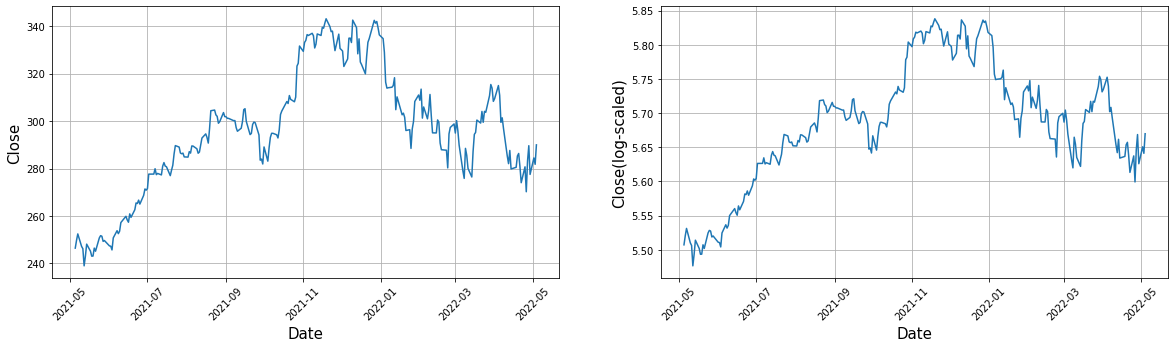

In [150]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(ts)
plt.xlabel("Date", size=15)
plt.ylabel("Close", size=15)
plt.xticks(rotation=45)
plt.grid()
plt.subplot(122)
plt.plot(ts_log)
plt.xlabel("Date", size=15)
plt.ylabel("Close(log-scaled)", size=15)
plt.xticks(rotation=45)
plt.grid()
plt.show()

### STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [151]:
augmented_dickey_fuller_test(ts)
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.117150
p-value                          0.237675
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -2.181663
p-value                          0.212968
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


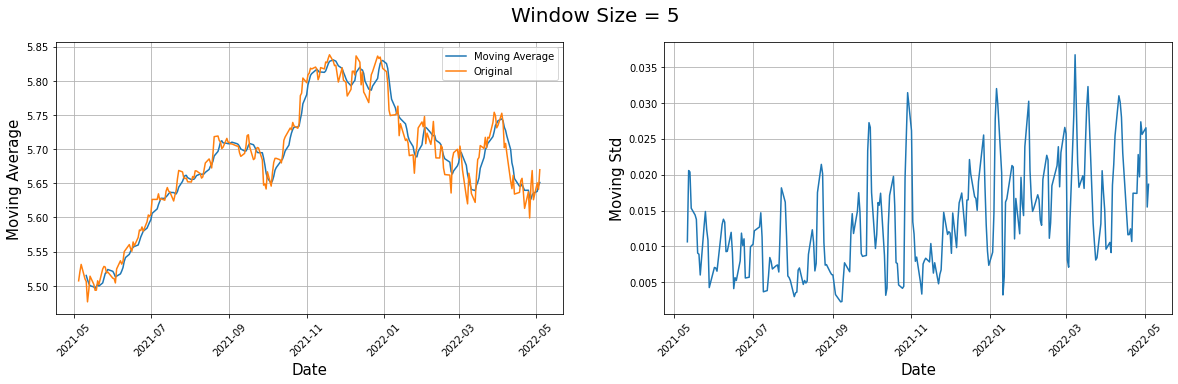

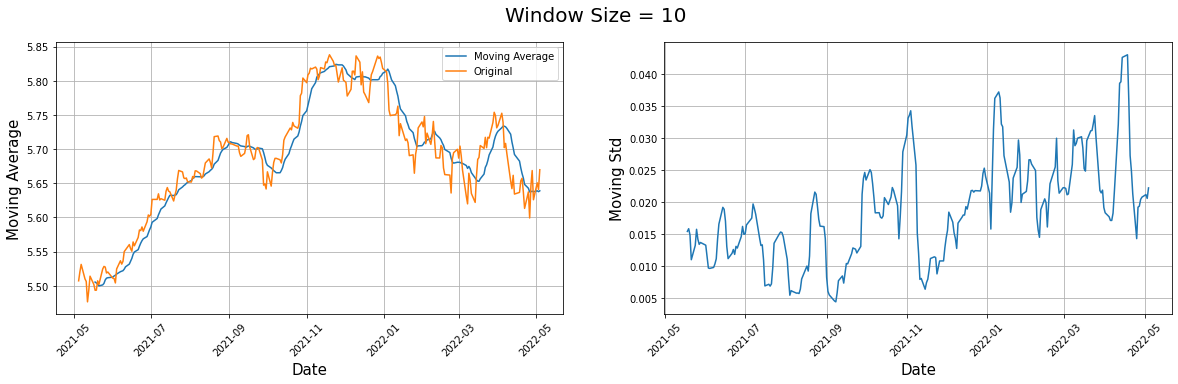

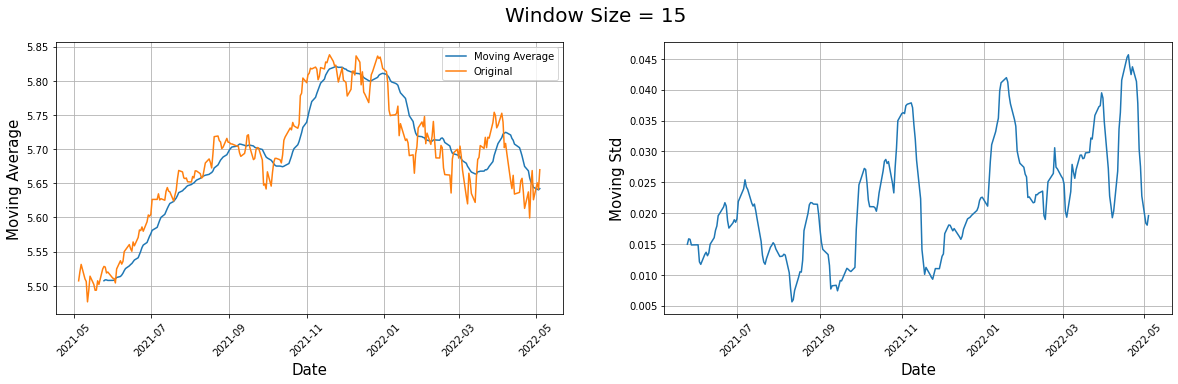

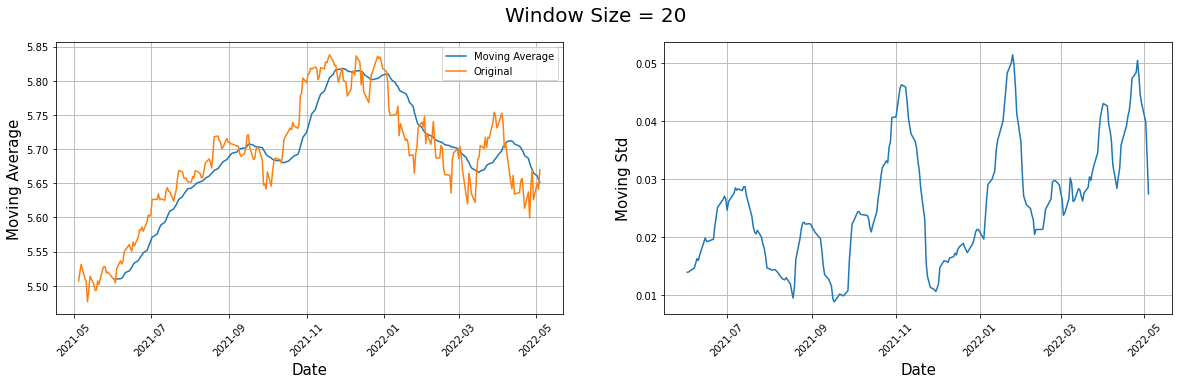

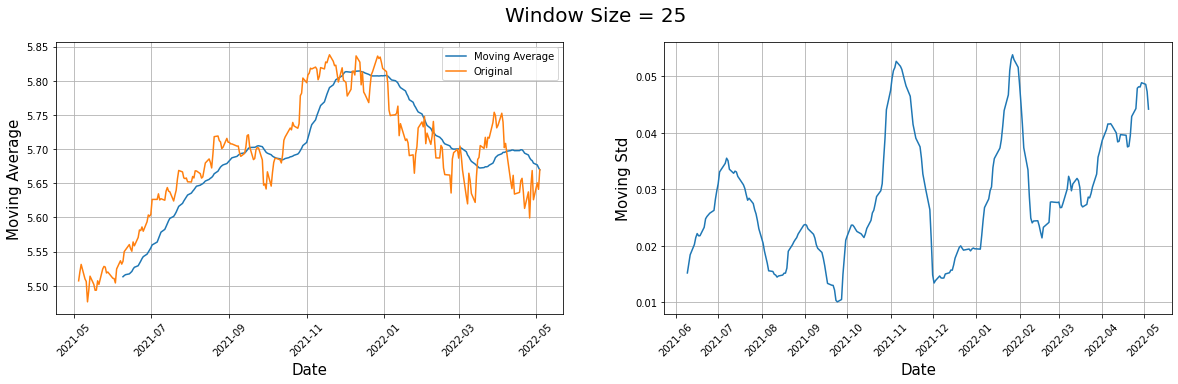

In [152]:
for i in range(5):
  window_size = 5 * (i + 1)

  rolmean = ts_log.rolling(window=window_size).mean()  # 이동평균 시계열
  rolstd = ts_log.rolling(window=window_size).std()    # 이동표준편차 시계열

  plt.figure(figsize=(20, 5))
  plt.subplot(121)
  plt.plot(rolmean, label="Moving Average")
  plt.plot(ts_log, label="Original")
  plt.legend()
  plt.xlabel("Date", size=15)
  plt.ylabel("Moving Average", size=15)
  plt.xticks(rotation=45)
  plt.grid()

  plt.subplot(122)
  plt.plot(rolstd)
  plt.xlabel("Date", size=15)
  plt.ylabel("Moving Std", size=15)
  plt.xticks(rotation=45)
  plt.grid()
  plt.suptitle("Window Size = {0}".format(window_size), fontsize=20)
  plt.show()

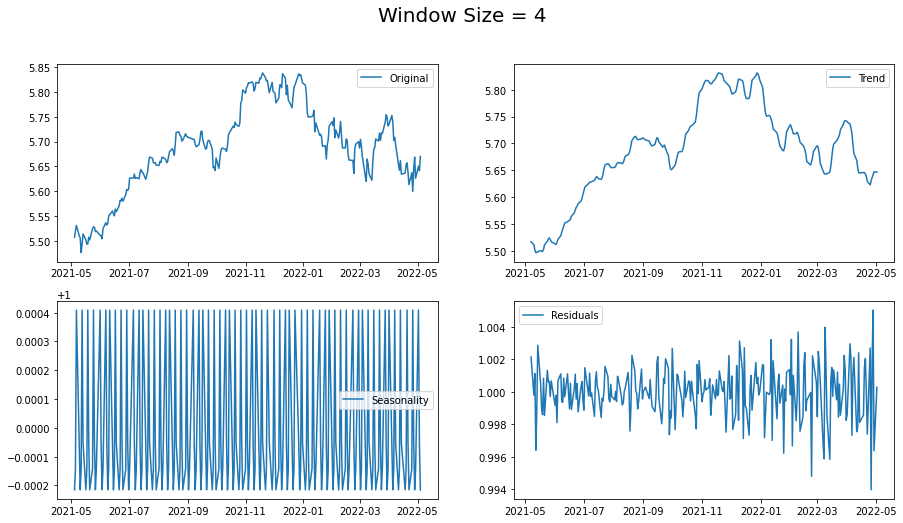

Results of Dickey-Fuller Test:
Test Statistic                -7.989373e+00
p-value                        2.498340e-12
#Lags Used                     1.100000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


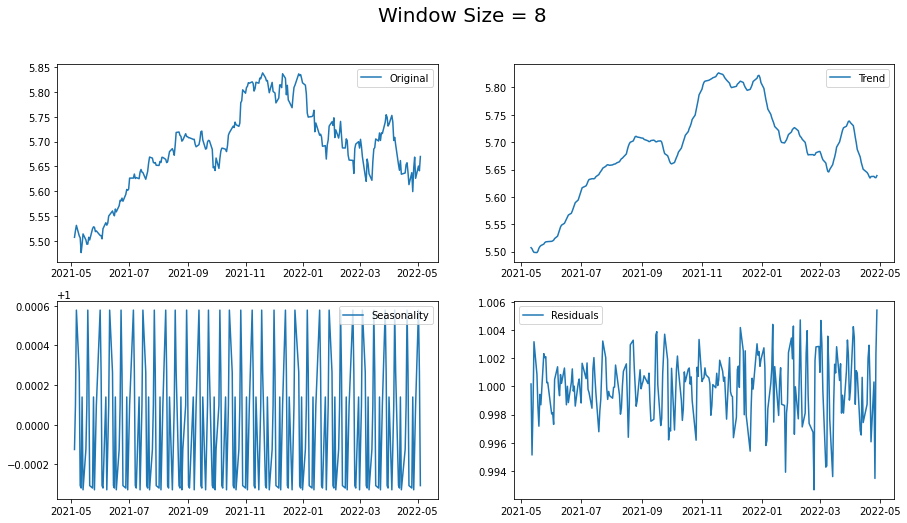

Results of Dickey-Fuller Test:
Test Statistic                -9.194001e+00
p-value                        2.086346e-15
#Lags Used                     7.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


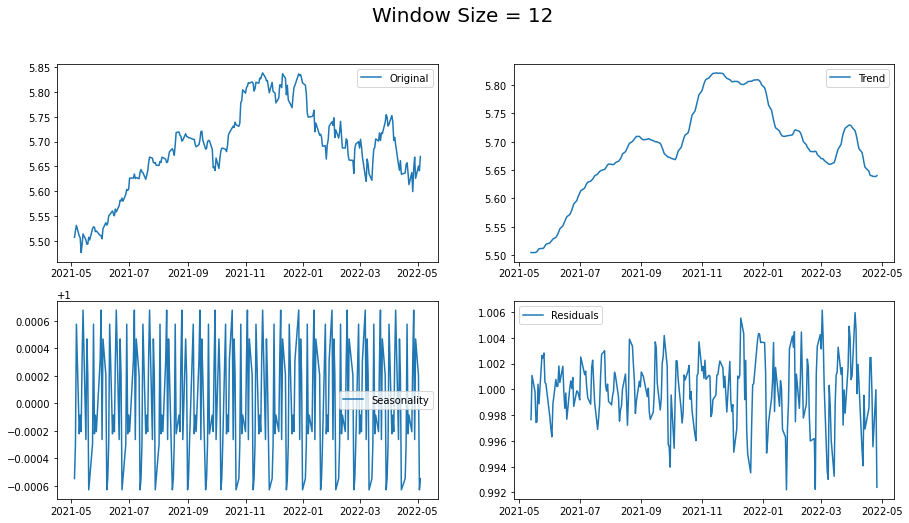

Results of Dickey-Fuller Test:
Test Statistic                -7.821857e+00
p-value                        6.637529e-12
#Lags Used                     7.000000e+00
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


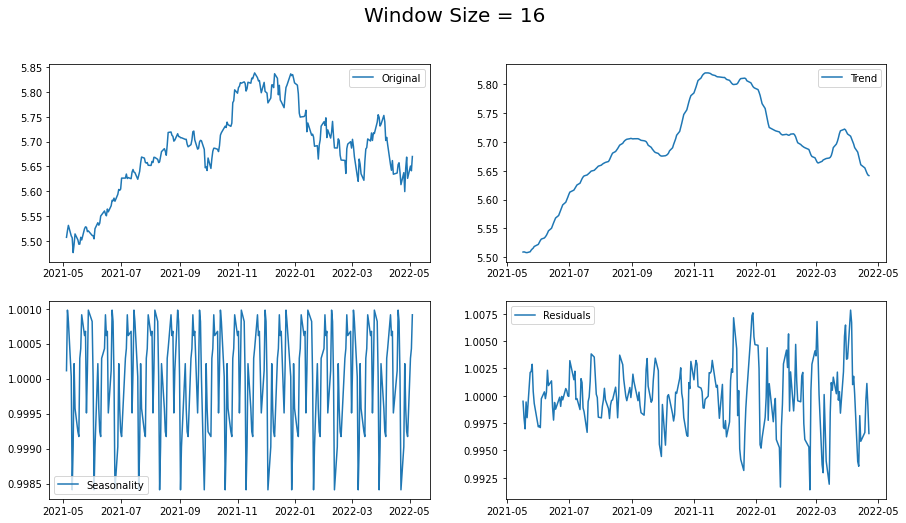

Results of Dickey-Fuller Test:
Test Statistic                -7.918858e+00
p-value                        3.771424e-12
#Lags Used                     5.000000e+00
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


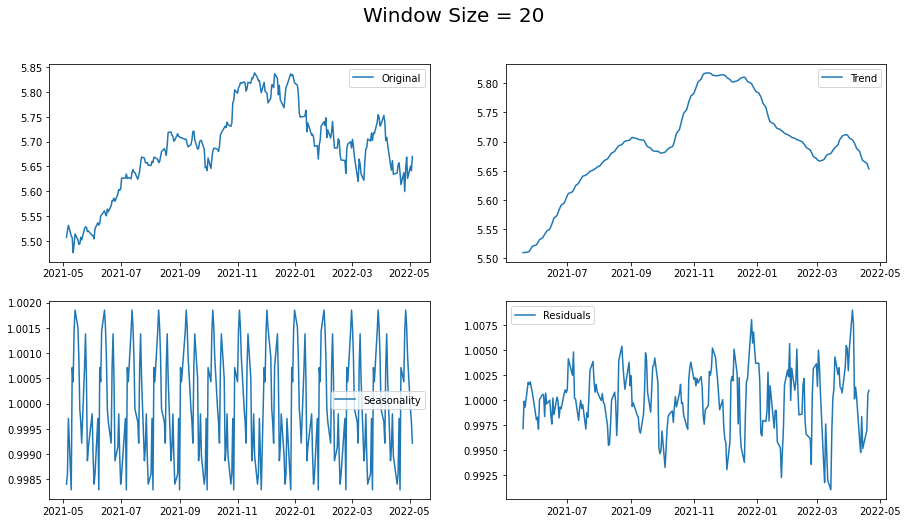

Results of Dickey-Fuller Test:
Test Statistic                -6.929808e+00
p-value                        1.091456e-09
#Lags Used                     5.000000e+00
Number of Observations Used    2.270000e+02
Critical Value (1%)           -3.459490e+00
Critical Value (5%)           -2.874358e+00
Critical Value (10%)          -2.573602e+00
dtype: float64


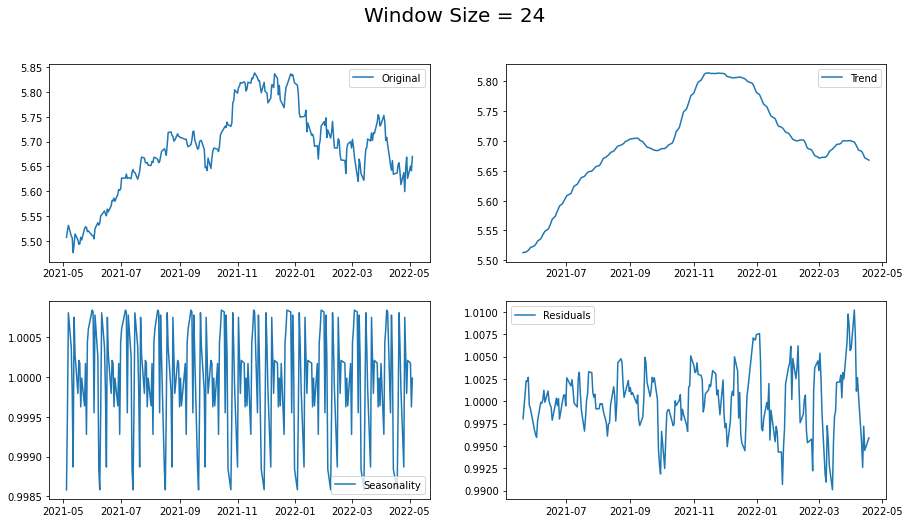

Results of Dickey-Fuller Test:
Test Statistic                -6.083180e+00
p-value                        1.079893e-07
#Lags Used                     7.000000e+00
Number of Observations Used    2.210000e+02
Critical Value (1%)           -3.460291e+00
Critical Value (5%)           -2.874709e+00
Critical Value (10%)          -2.573789e+00
dtype: float64


In [153]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose

for i in range(6):
  window_size = 4 * (i + 1)
  decomposition = seasonal_decompose(ts_log, model='multiplicative', period = window_size) 

  trend = decomposition.trend
  seasonal = decomposition.seasonal
  residual = decomposition.resid

  plt.figure(figsize=(15, 8))
  plt.subplot(221)
  plt.plot(ts_log, label='Original')
  plt.legend(loc='best')
  plt.subplot(222)
  plt.plot(trend, label='Trend')
  plt.legend(loc='best')
  plt.subplot(223)
  plt.plot(seasonal,label='Seasonality')
  plt.legend(loc='best')
  plt.subplot(224)
  plt.plot(residual, label='Residuals')
  plt.legend(loc='best')
  plt.suptitle("Window Size = {0}".format(window_size), fontsize=20)
  plt.show()
  
  residual.dropna(inplace=True)
  augmented_dickey_fuller_test(residual)

### STEP 4 : 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

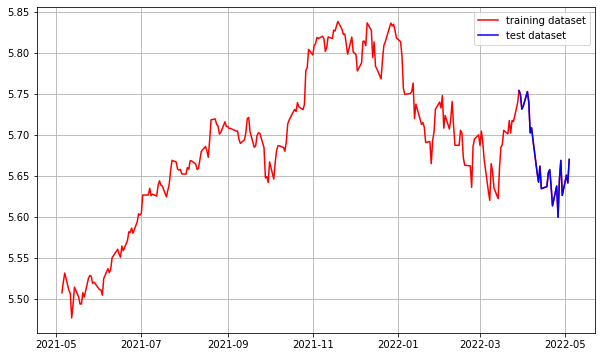

In [154]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


### STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


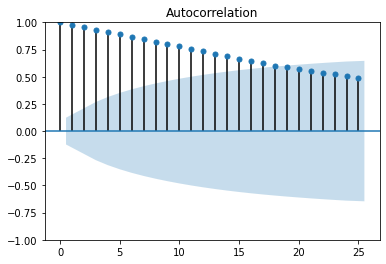

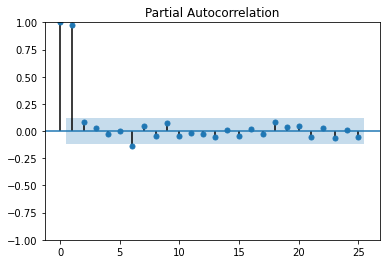

In [155]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.721475e+01
p-value                        6.335447e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.982681e+00
p-value                        2.597988e-12
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


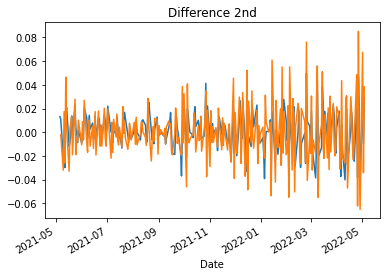

In [108]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# 학습 및 평가(step6)
- train 데이터셋을 이용한 모델 학습
  - ARIMA 모델 학습 수행
- test 데이터셋 평가

### STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [161]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 629.246
Date:                Thu, 05 May 2022   AIC                          -1250.492
Time:                        13:24:14   BIC                          -1236.792
Sample:                             0   HQIC                         -1244.964
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6561      0.060     93.888      0.000       5.538       5.774
ar.L1          0.9903      0.009    105.212      0.000       0.972       1.009
ma.L1         -0.0357      0.064     -0.557      0.5

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


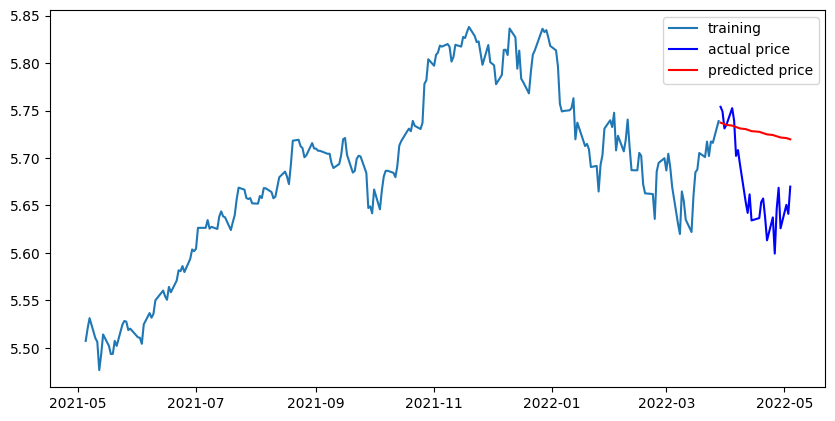

In [162]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [163]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  410.2108228232413
MAE:  17.522661022902874
RMSE:  20.253661960821834
MAPE: 6.18%


In [164]:
from google.colab import files
file_uploaded = files.upload()

Saving AAPL.csv to AAPL (2).csv


In [165]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# dataset_filepath = "G:/내 드라이브/0. 인공지능 학습/아이펠 대전 3기/2. Exploration 수업/코드/3강/005930.KS.csv"

df = pd.read_csv(io.BytesIO(file_uploaded['AAPL.csv']), index_col='Date', parse_dates=True)
df.tail()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-04-28  159.250000  164.520004  158.929993  163.639999  163.639999   
2022-04-29  161.839996  166.199997  157.250000  157.649994  157.649994   
2022-05-02  156.710007  158.229996  153.270004  157.960007  157.960007   
2022-05-03  158.149994  160.710007  156.320007  159.479996  159.479996   
2022-05-04  159.669998  166.479996  159.259995  166.020004  166.020004   

               Volume  
Date                   
2022-04-28  130216800  
2022-04-29  131587100  
2022-05-02  123055300  
2022-05-03   88966500  
2022-05-04  108101500

In [166]:
print(df.keys())
print(df.shape)
print(df.Close.dtype)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
(253, 6)
float64


In [167]:
# 데이터 프레임의 Close 열만을 따로 사용하여 시계열 데이터로 변환함.
ts = df['Close']
print(type(ts))
print('\n\n')
print(ts.tail())
print('\n\n')
print(ts.describe())

<class 'pandas.core.series.Series'>



Date
2022-04-28    163.639999
2022-04-29    157.649994
2022-05-02    157.960007
2022-05-03    159.479996
2022-05-04    166.020004
Name: Close, dtype: float64



count    253.000000
mean     153.822293
std       15.632815
min      122.769997
25%      144.979996
50%      151.119995
75%      166.559998
max      182.009995
Name: Close, dtype: float64


### STEP 2 : 각종 전처리 수행
- 결측치 처리
- 로그 변환

In [168]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [169]:
# 로그 변환 시도 
ts_log = np.log(ts)

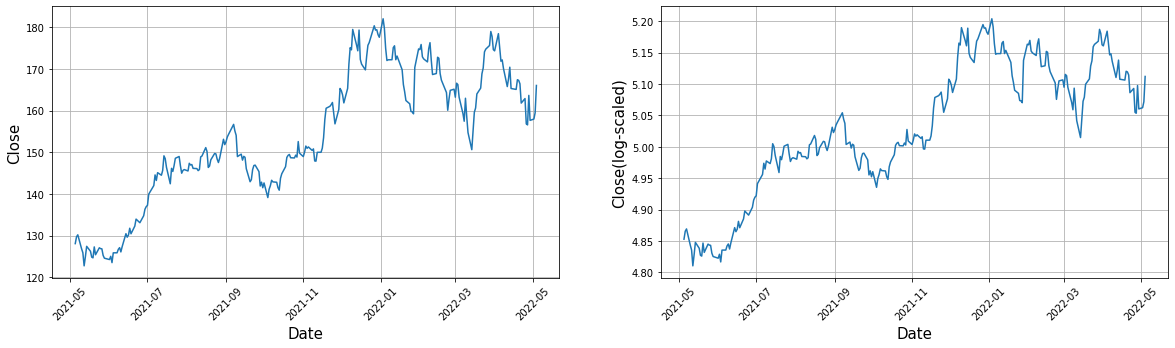

In [170]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(ts)
plt.xlabel("Date", size=15)
plt.ylabel("Close", size=15)
plt.xticks(rotation=45)
plt.grid()
plt.subplot(122)
plt.plot(ts_log)
plt.xlabel("Date", size=15)
plt.ylabel("Close(log-scaled)", size=15)
plt.xticks(rotation=45)
plt.grid()
plt.show()

### STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [171]:
augmented_dickey_fuller_test(ts)
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.803850
p-value                          0.378552
#Lags Used                       8.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -1.886170
p-value                          0.338595
#Lags Used                       8.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


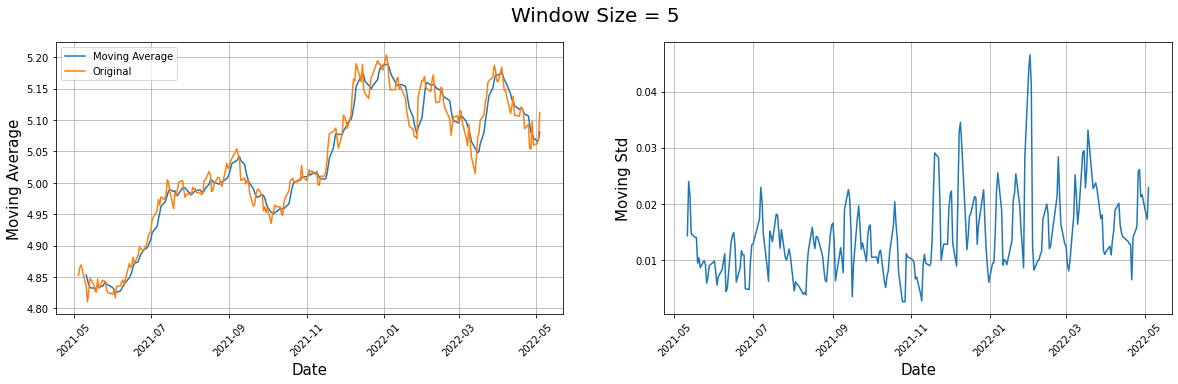

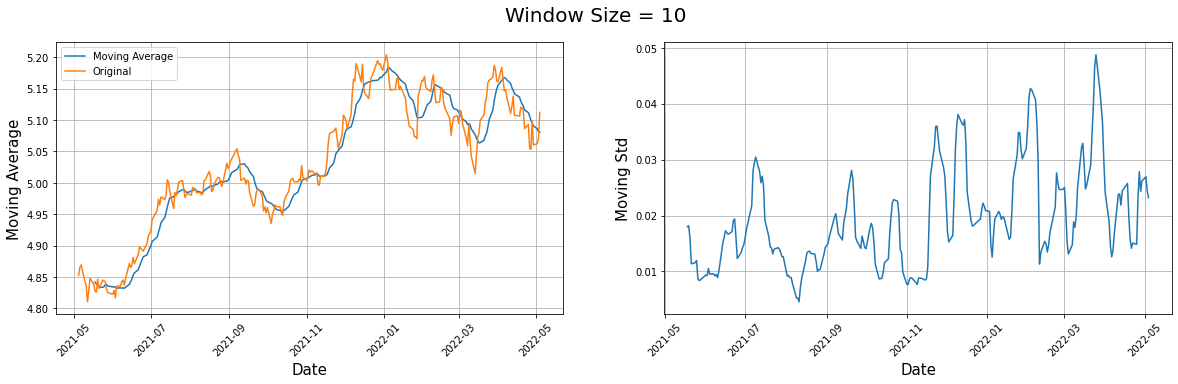

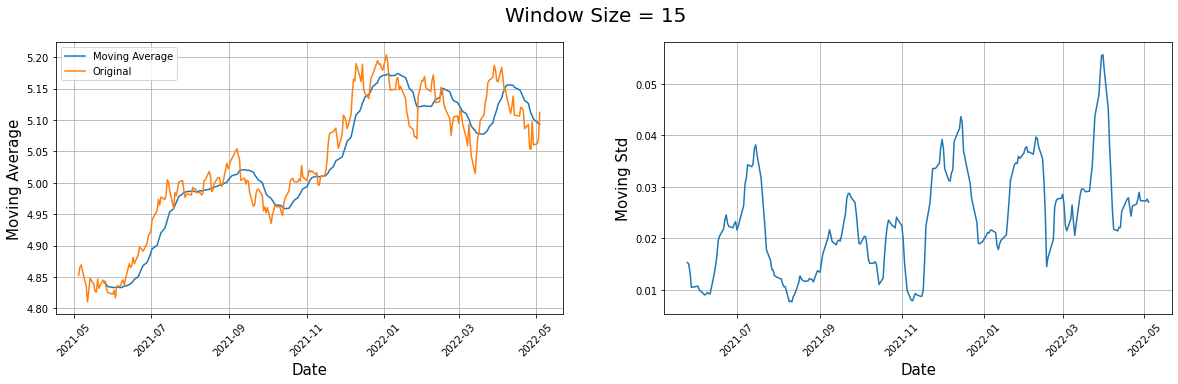

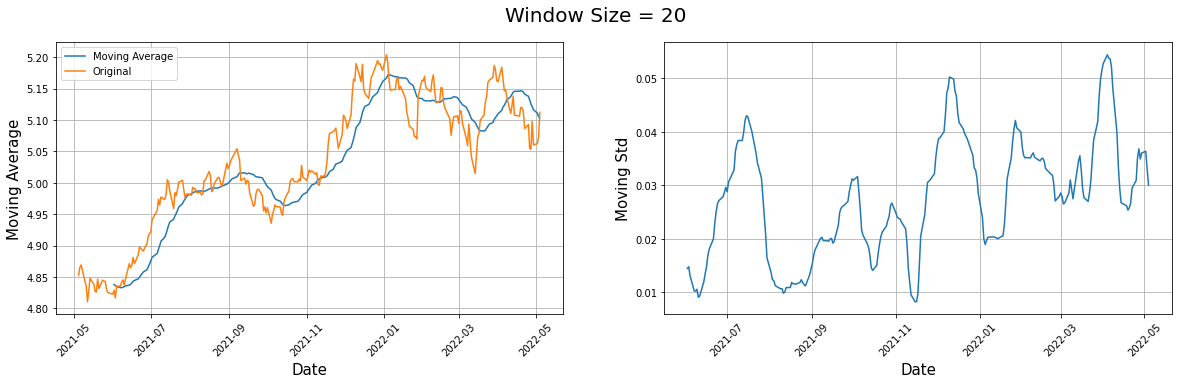

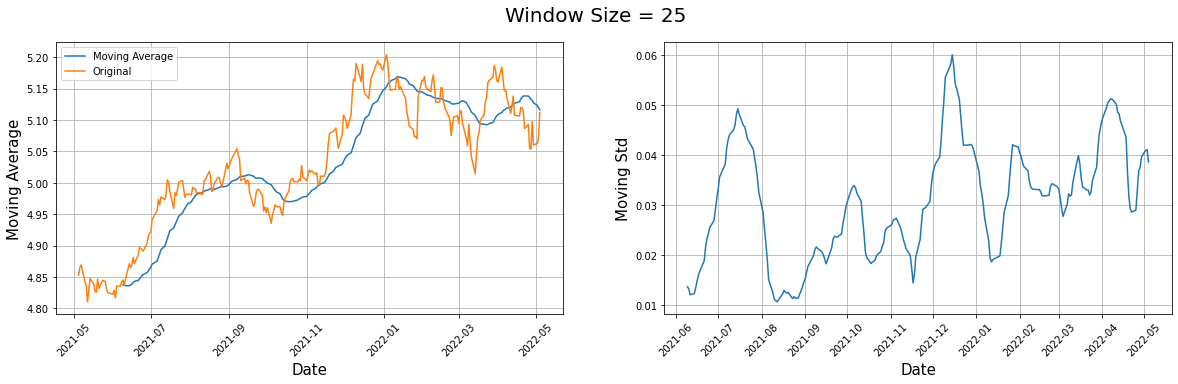

In [172]:
for i in range(5):
  window_size = 5 * (i + 1)

  rolmean = ts_log.rolling(window=window_size).mean()  # 이동평균 시계열
  rolstd = ts_log.rolling(window=window_size).std()    # 이동표준편차 시계열

  plt.figure(figsize=(20, 5))
  plt.subplot(121)
  plt.plot(rolmean, label="Moving Average")
  plt.plot(ts_log, label="Original")
  plt.legend()
  plt.xlabel("Date", size=15)
  plt.ylabel("Moving Average", size=15)
  plt.xticks(rotation=45)
  plt.grid()

  plt.subplot(122)
  plt.plot(rolstd)
  plt.xlabel("Date", size=15)
  plt.ylabel("Moving Std", size=15)
  plt.xticks(rotation=45)
  plt.grid()
  plt.suptitle("Window Size = {0}".format(window_size), fontsize=20)
  plt.show()

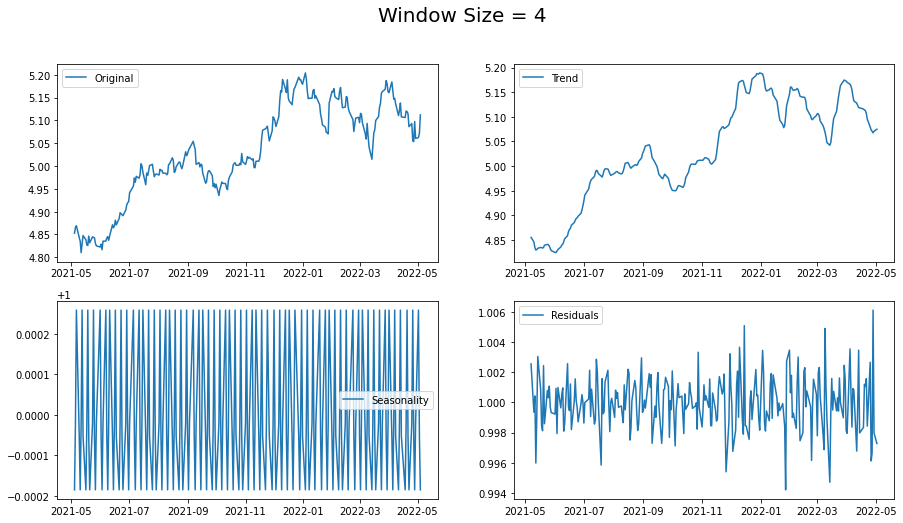

Results of Dickey-Fuller Test:
Test Statistic                -7.692863e+00
p-value                        1.404138e-11
#Lags Used                     1.200000e+01
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


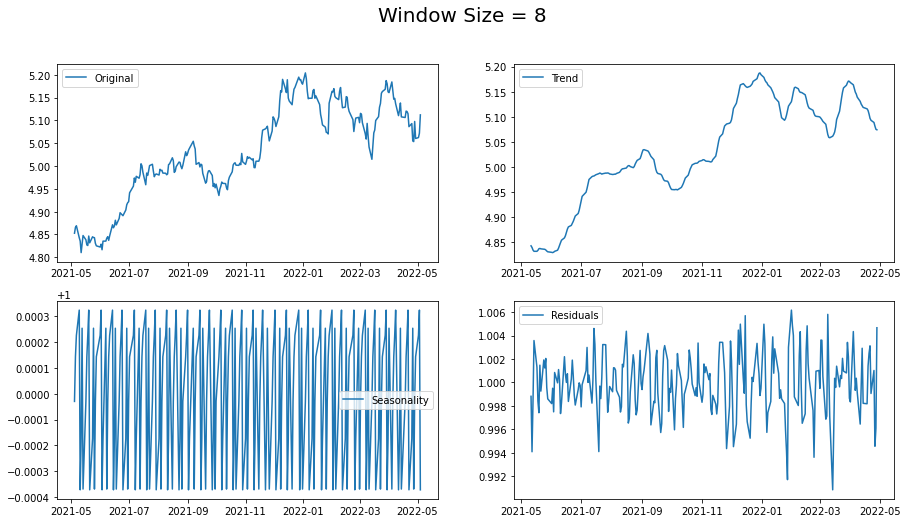

Results of Dickey-Fuller Test:
Test Statistic                -9.052133e+00
p-value                        4.808162e-15
#Lags Used                     7.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


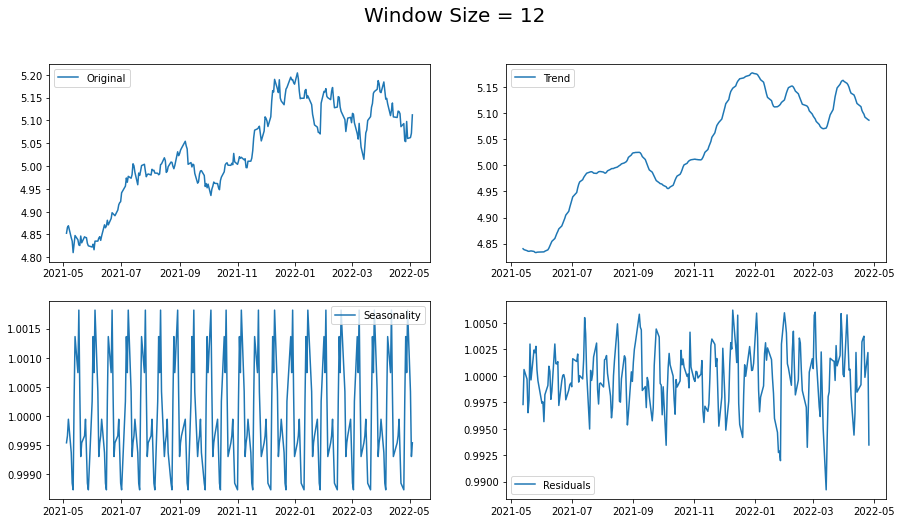

Results of Dickey-Fuller Test:
Test Statistic                -8.298071e+00
p-value                        4.088550e-13
#Lags Used                     7.000000e+00
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


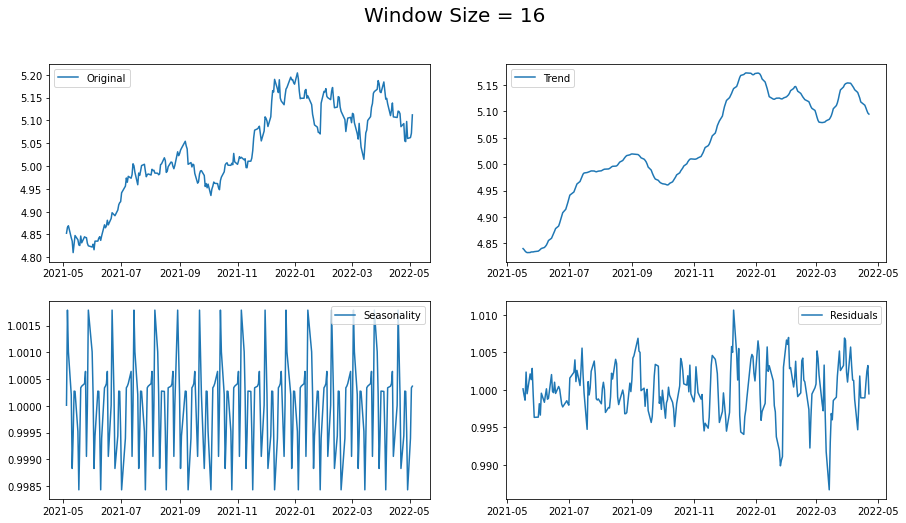

Results of Dickey-Fuller Test:
Test Statistic                -5.715121e+00
p-value                        7.150350e-07
#Lags Used                     1.500000e+01
Number of Observations Used    2.210000e+02
Critical Value (1%)           -3.460291e+00
Critical Value (5%)           -2.874709e+00
Critical Value (10%)          -2.573789e+00
dtype: float64


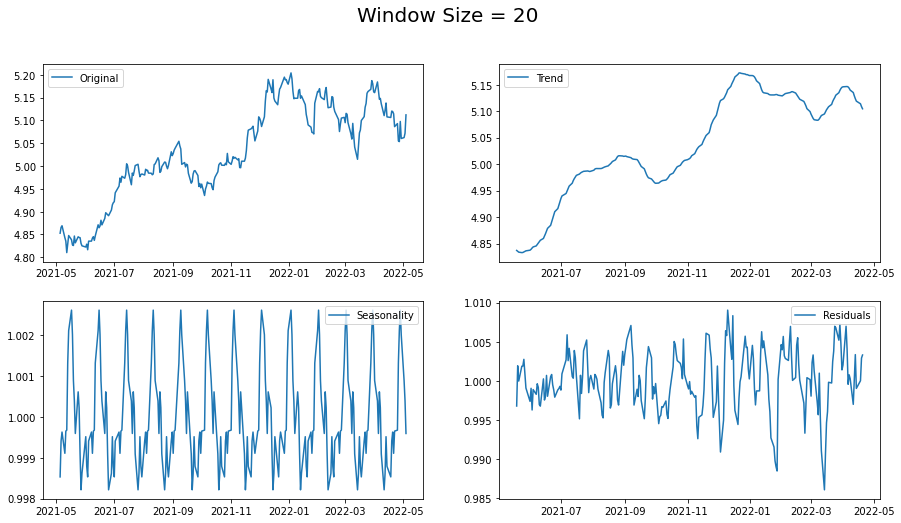

Results of Dickey-Fuller Test:
Test Statistic                  -4.843702
p-value                          0.000045
#Lags Used                      14.000000
Number of Observations Used    218.000000
Critical Value (1%)             -3.460708
Critical Value (5%)             -2.874891
Critical Value (10%)            -2.573886
dtype: float64


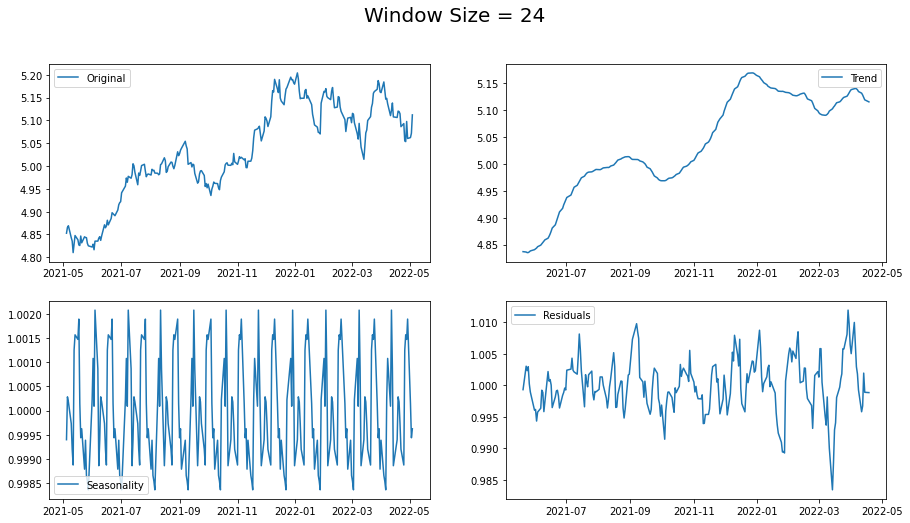

Results of Dickey-Fuller Test:
Test Statistic                -6.562466e+00
p-value                        8.315183e-09
#Lags Used                     7.000000e+00
Number of Observations Used    2.210000e+02
Critical Value (1%)           -3.460291e+00
Critical Value (5%)           -2.874709e+00
Critical Value (10%)          -2.573789e+00
dtype: float64


In [173]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose

for i in range(6):
  window_size = 4 * (i + 1)
  decomposition = seasonal_decompose(ts_log, model='multiplicative', period = window_size) 

  trend = decomposition.trend
  seasonal = decomposition.seasonal
  residual = decomposition.resid

  plt.figure(figsize=(15, 8))
  plt.subplot(221)
  plt.plot(ts_log, label='Original')
  plt.legend(loc='best')
  plt.subplot(222)
  plt.plot(trend, label='Trend')
  plt.legend(loc='best')
  plt.subplot(223)
  plt.plot(seasonal,label='Seasonality')
  plt.legend(loc='best')
  plt.subplot(224)
  plt.plot(residual, label='Residuals')
  plt.legend(loc='best')
  plt.suptitle("Window Size = {0}".format(window_size), fontsize=20)
  plt.show()
  
  residual.dropna(inplace=True)
  augmented_dickey_fuller_test(residual)

### STEP 4 : 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

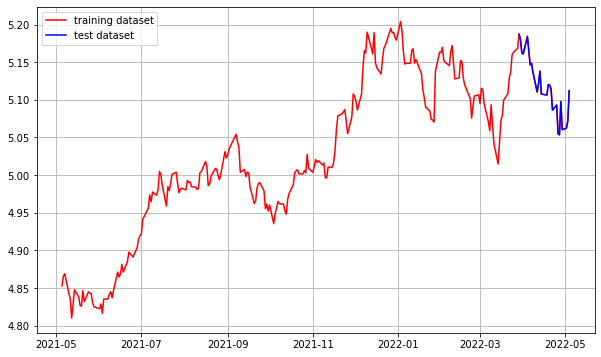

In [174]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


### STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


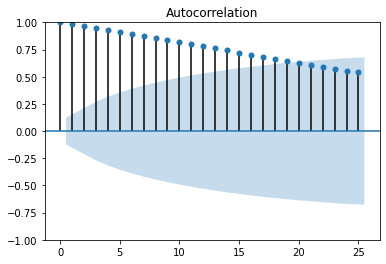

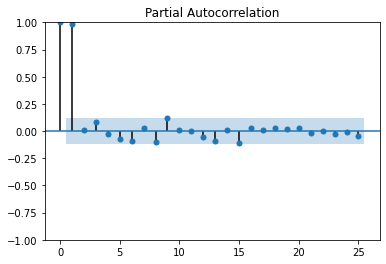

In [175]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -5.962846e+00
p-value                        2.019839e-07
#Lags Used                     7.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.010006e+00
p-value                        2.214424e-12
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


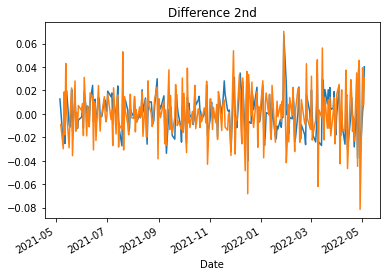

In [176]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# 학습 및 평가(step6)
- train 데이터셋을 이용한 모델 학습
  - ARIMA 모델 학습 수행
- test 데이터셋 평가

### STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [180]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 2))  
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 626.085
Date:                Thu, 05 May 2022   AIC                          -1240.169
Time:                        13:25:07   BIC                          -1219.619
Sample:                             0   HQIC                         -1231.877
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0204      0.040    126.549      0.000       4.943       5.098
ar.L1          1.1349      2.197      0.517      0.605      -3.171       5.441
ar.L2         -0.1504      2.155     -0.070      0.9

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


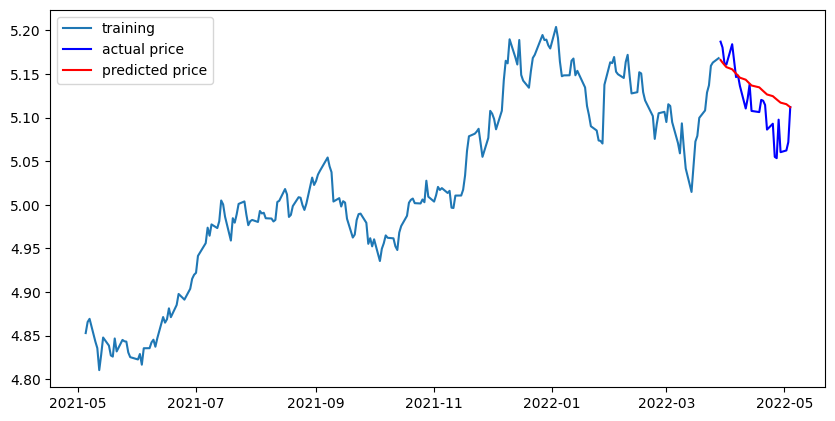

In [181]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [182]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  26.453286416010222
MAE:  4.002236778113842
RMSE:  5.1432758448298515
MAPE: 2.45%
